# E. Coli Classification using AutoML TPOT: A Study Case of E Coli Dataset for Advance Machine Learning

**Video URL**: https://youtu.be/Oo734q5V_LY

**Members**:

- Ikhsan Assidiqie
- M. Ridho Sunation
- M. Hanif
- Aufa Rafiqi Muljana

A type of bacteria that commonly lives in the intestines of humans and animals. While most strains of E. coli are harmless and play a crucial role in maintaining gut health, some strains can cause severe food poisoning and other infections. These pathogenic strains can lead to symptoms such as diarrhea, urinary tract infections, respiratory illness, and more severe complications like hemolytic uremic syndrome (HUS).

Classification of E. coli using machine learning is essential for several reasons:

- Early Detection and Prevention: By classifying different strains accurately, it's possible to detect pathogenic strains early, preventing potential outbreaks and protecting public health.
- Efficient Diagnosis: Machine learning models can analyze large datasets quickly and accurately, aiding in the rapid diagnosis of infections, which is critical for timely treatment.
- Antibiotic Resistance Management: Classification helps in identifying strains that are resistant to antibiotics, enabling healthcare providers to choose the most effective treatment and manage antibiotic resistance better.
- Surveillance and Research: Machine learning aids in tracking the spread of different E. coli strains, understanding their evolution, and conducting research to develop better treatment and prevention strategies.

## Methodology

<img src='fig/methodology-flowchart.drawio.png'></img>

## Preparing

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from scipy import stats

from tpot import *

import os
import time

import warnings
warnings.filterwarnings('ignore')


#### ARFF Convert to CSV

Only run this section if the dataset is `.arff` extension instead of `.csv` file.

In [79]:
path_to_directory="data/"
files = [arff for arff in os.listdir(path_to_directory) if arff.endswith(".arff")]

def toCsv(content): 
    data = False
    header = ""
    newContent = []
    for line in content:
        if not data:
            if "@attribute" in line:
                attri = line.split()
                columnName = attri[attri.index("@attribute")+1]
                header = header + columnName + ","
            elif "@data" in line:
                data = True
                header = header[:-1]
                header += '\n'
                newContent.append(header)
        else:
            newContent.append(line)
    return newContent

for zzzz, file in enumerate(files):
    with open(path_to_directory+file , "r") as inFile:
        content = inFile.readlines()
        name,ext = os.path.splitext(inFile.name)
        new = toCsv(content)
        with open(name+".csv", "w") as outFile:
            outFile.writelines(new)


#### Loading CSV Dataset of E. Coli

In [80]:
raw = pd.read_csv("data/dataset_39_ecoli.csv") # reading the dataset

raw.columns = ['mcg', 'gvh', 'lip', 'chg', 'aac', 'alm1', 'alm2', 'class'] # removing the double quotes from the column names
raw.columns = raw.columns.str.replace("'", "",) # removing the single quotes from the column names

raw, raw.info(), raw['class'].unique()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mcg     336 non-null    float64
 1   gvh     336 non-null    float64
 2   lip     336 non-null    float64
 3   chg     336 non-null    float64
 4   aac     336 non-null    float64
 5   alm1    336 non-null    float64
 6   alm2    336 non-null    float64
 7   class   336 non-null    object 
dtypes: float64(7), object(1)
memory usage: 21.1+ KB


(      mcg   gvh   lip  chg   aac  alm1  alm2 class
 0    0.49  0.29  0.48  0.5  0.56  0.24  0.35    cp
 1    0.07  0.40  0.48  0.5  0.54  0.35  0.44    cp
 2    0.56  0.40  0.48  0.5  0.49  0.37  0.46    cp
 3    0.59  0.49  0.48  0.5  0.52  0.45  0.36    cp
 4    0.23  0.32  0.48  0.5  0.55  0.25  0.35    cp
 ..    ...   ...   ...  ...   ...   ...   ...   ...
 331  0.74  0.56  0.48  0.5  0.47  0.68  0.30    pp
 332  0.71  0.57  0.48  0.5  0.48  0.35  0.32    pp
 333  0.61  0.60  0.48  0.5  0.44  0.39  0.38    pp
 334  0.59  0.61  0.48  0.5  0.42  0.42  0.37    pp
 335  0.74  0.74  0.48  0.5  0.31  0.53  0.52    pp
 
 [336 rows x 8 columns],
 None,
 array(['cp', 'im', 'imS', 'imL', 'imU', 'om', 'omL', 'pp'], dtype=object))

Information for the target class:

- cp (cytoplasm) 143 
- im (inner membrane without signal sequence) 77
- pp (perisplasm) 52 
- imU (inner membrane, uncleavable signal sequence) 35 
- om (outer membrane) 20 
- omL (outer membrane lipoprotein) 5 
- imL (inner membrane lipoprotein) 2 
- imS (inner membrane, cleavable signal sequence) 2

In [81]:
raw.dtypes, raw.describe().T

(mcg      float64
 gvh      float64
 lip      float64
 chg      float64
 aac      float64
 alm1     float64
 alm2     float64
 class     object
 dtype: object,
       count      mean       std   min   25%    50%     75%   max
 mcg   336.0  0.500060  0.194634  0.00  0.34  0.500  0.6625  0.89
 gvh   336.0  0.500000  0.148157  0.16  0.40  0.470  0.5700  1.00
 lip   336.0  0.495476  0.088495  0.48  0.48  0.480  0.4800  1.00
 chg   336.0  0.501488  0.027277  0.50  0.50  0.500  0.5000  1.00
 aac   336.0  0.500030  0.122376  0.00  0.42  0.495  0.5700  0.88
 alm1  336.0  0.500179  0.215751  0.03  0.33  0.455  0.7100  1.00
 alm2  336.0  0.499732  0.209411  0.00  0.35  0.430  0.7100  0.99)

## Exploratory Data Analysis

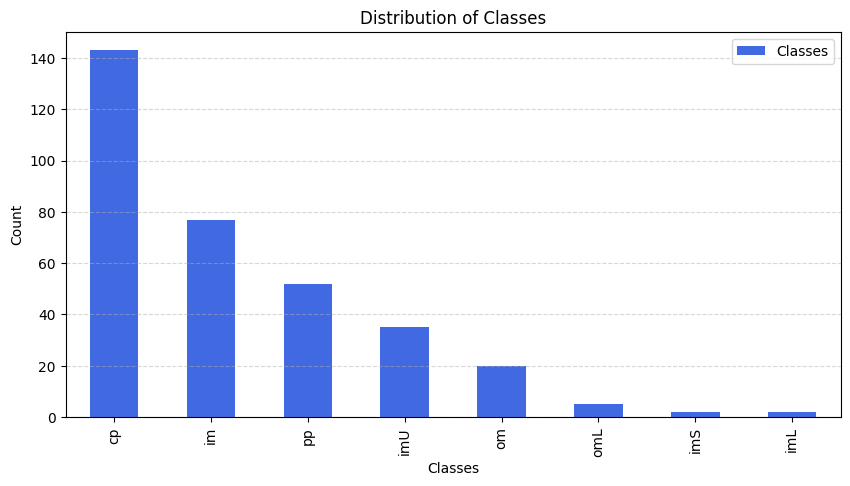

In [82]:
plt.figure(figsize=(10, 5))

raw['class'].value_counts().plot(kind='bar', color='royalblue', label='Classes')
plt.title('Distribution of Classes')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.legend()
plt.show()

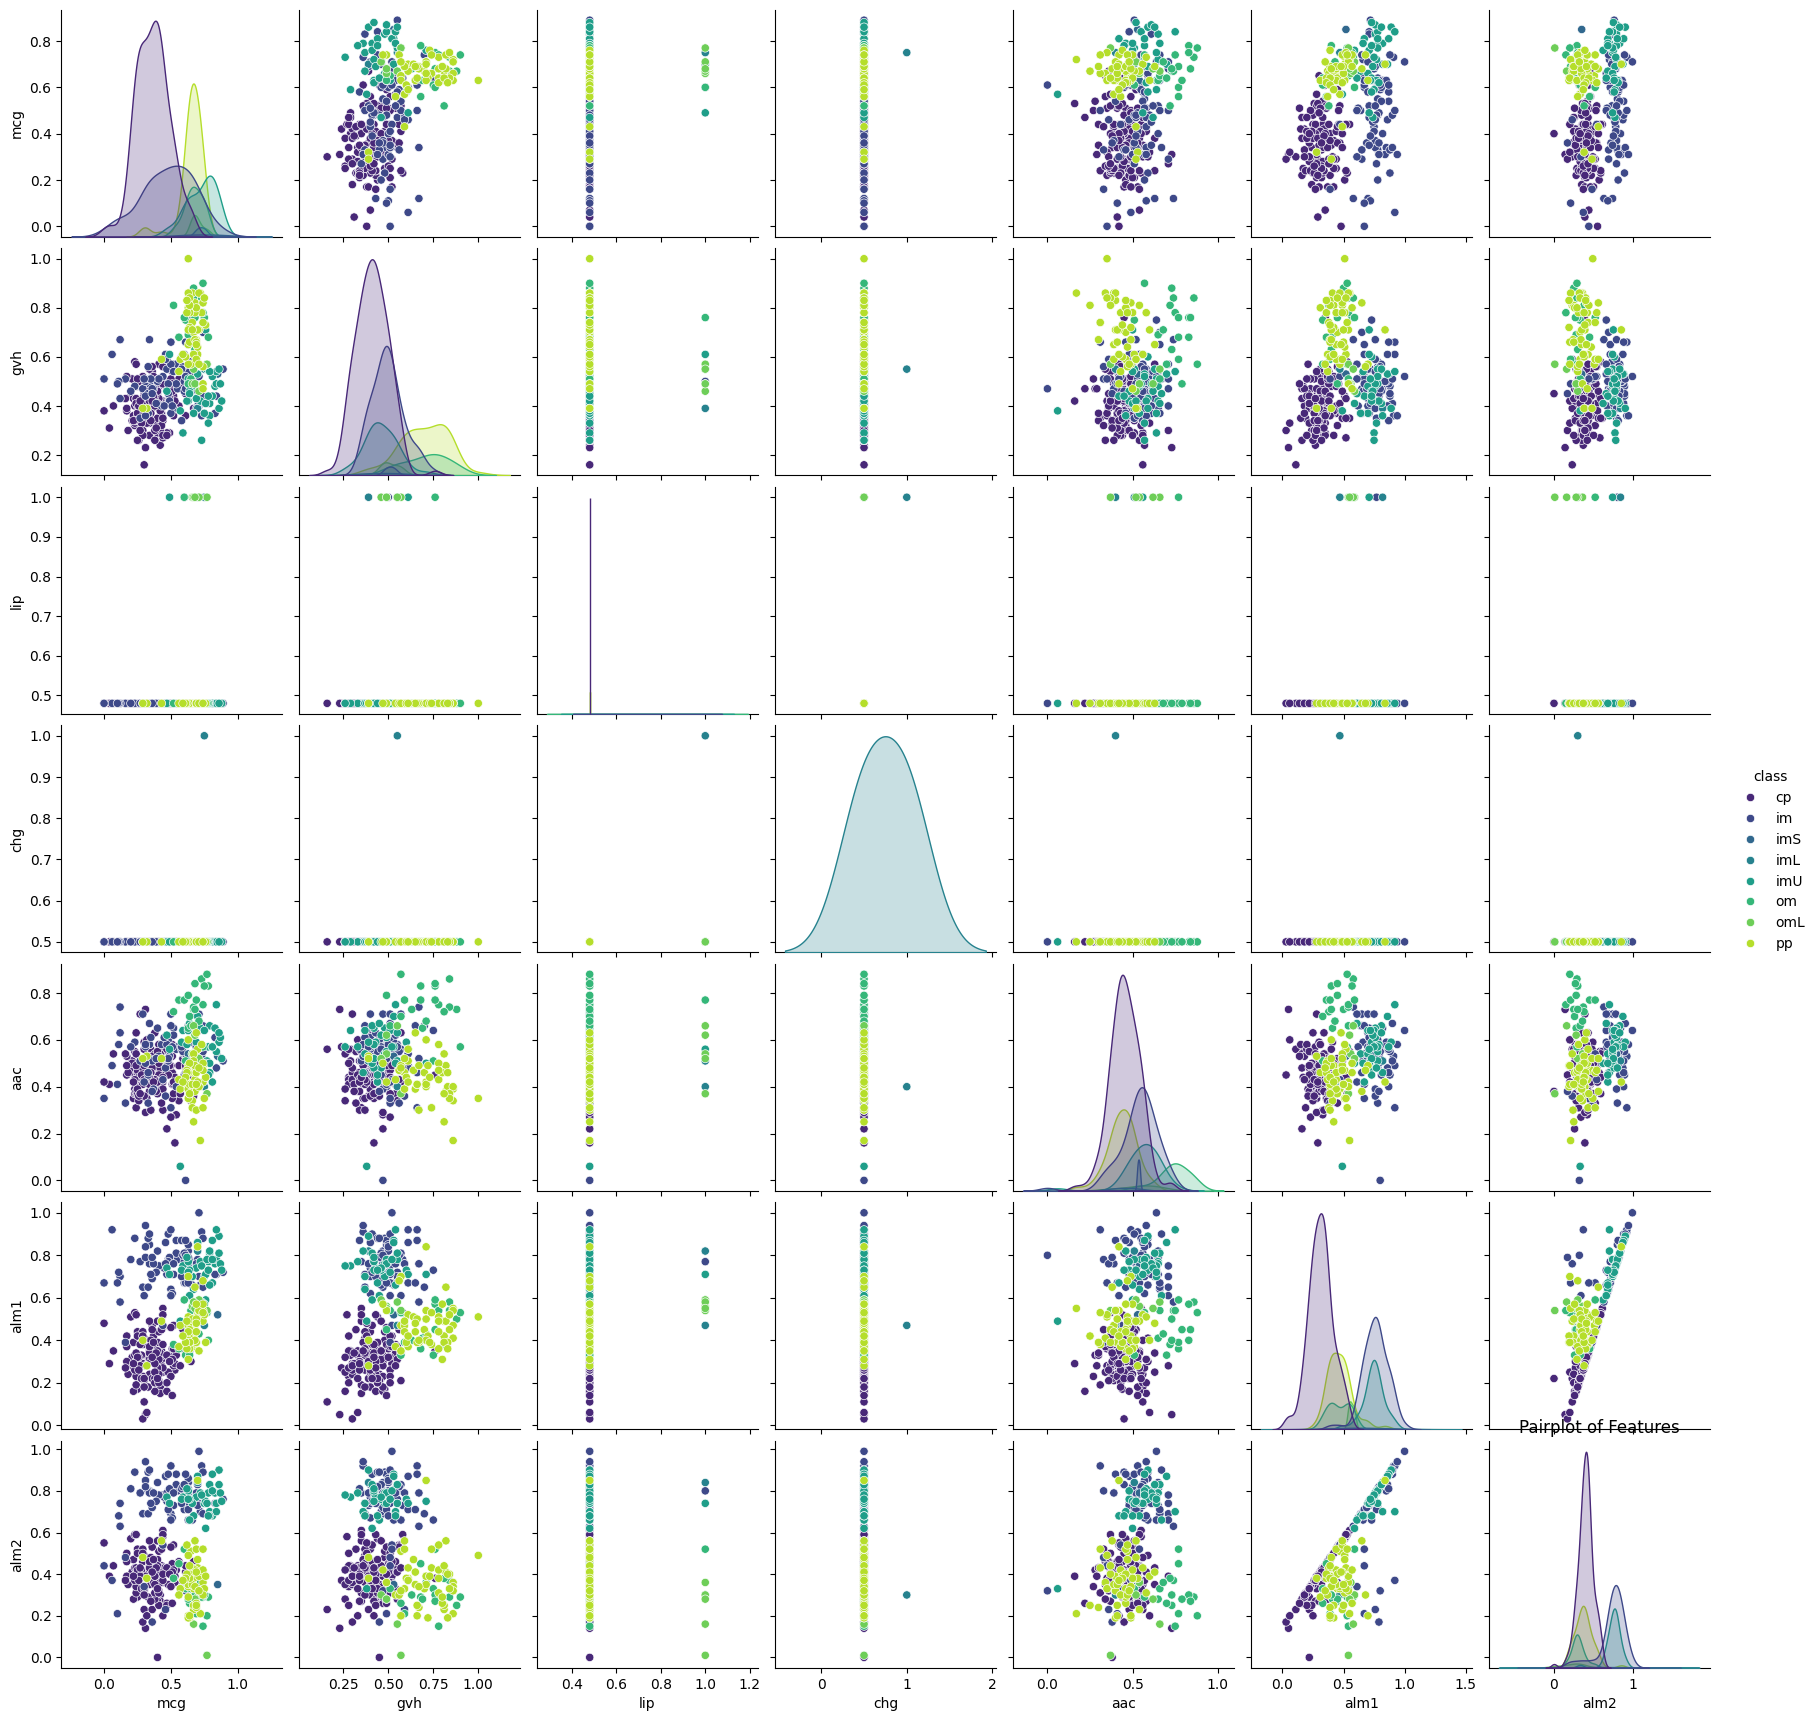

In [83]:
sns.pairplot(raw, hue='class', palette='viridis')
plt.title('Pairplot of Features')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

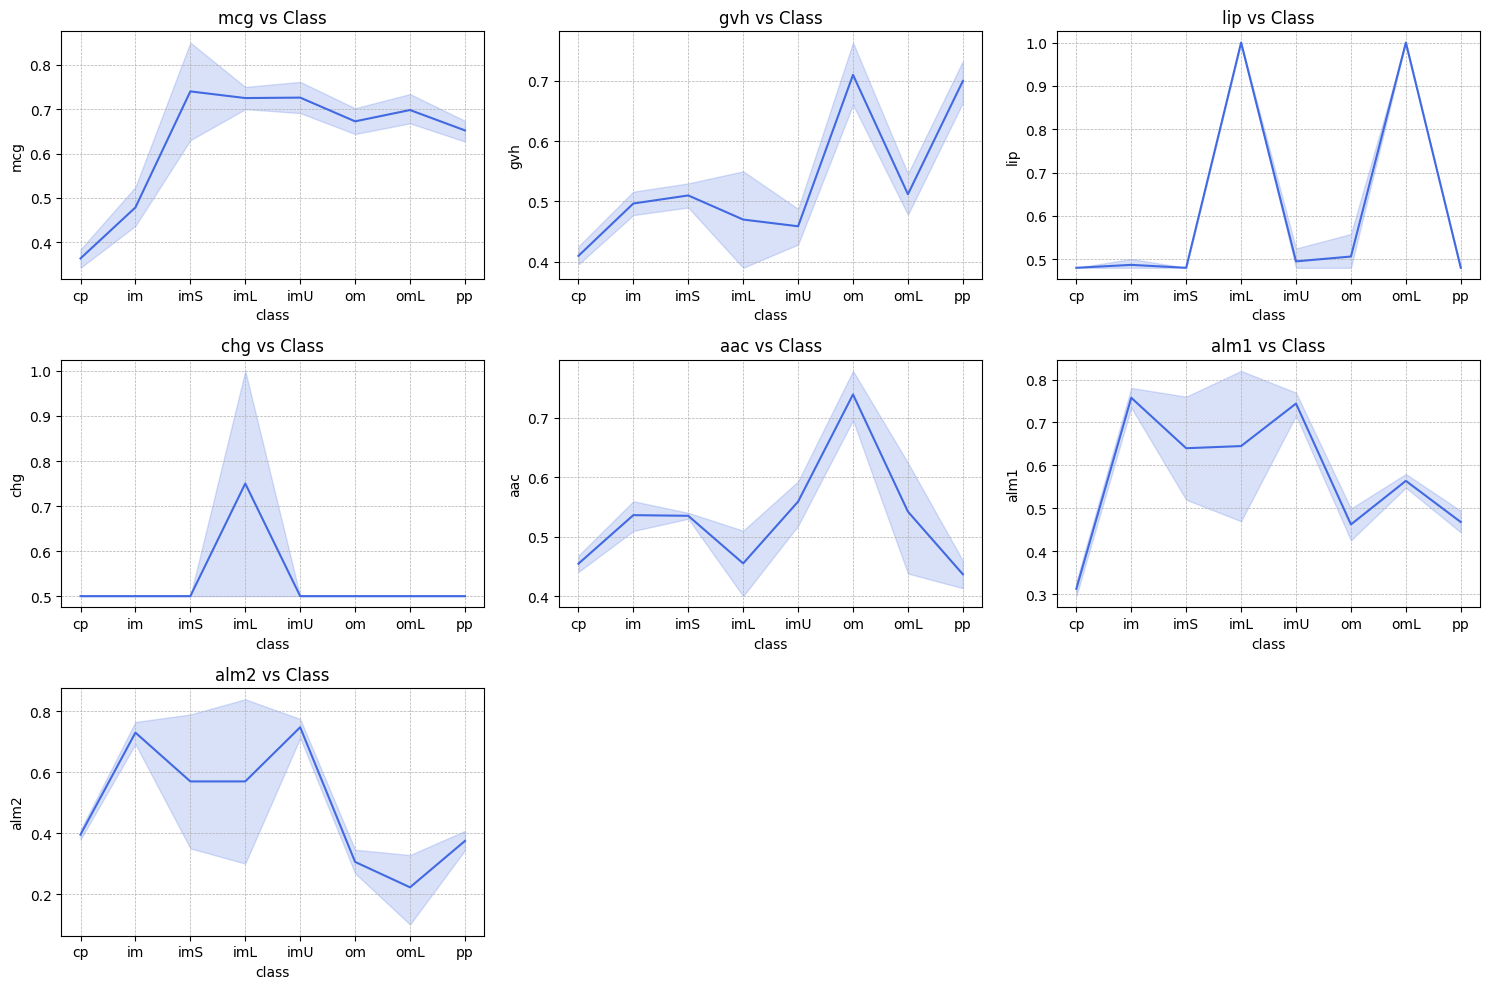

In [84]:
plt.figure(figsize=(15, 10))

for i, col in enumerate(raw.select_dtypes(include='float64').columns):
    plt.subplot(3, 3, i+1)
    sns.lineplot(data=raw, x='class', y=col, palette='viridis', color='royalblue')
    plt.title(f'{col} vs Class')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
plt.show()

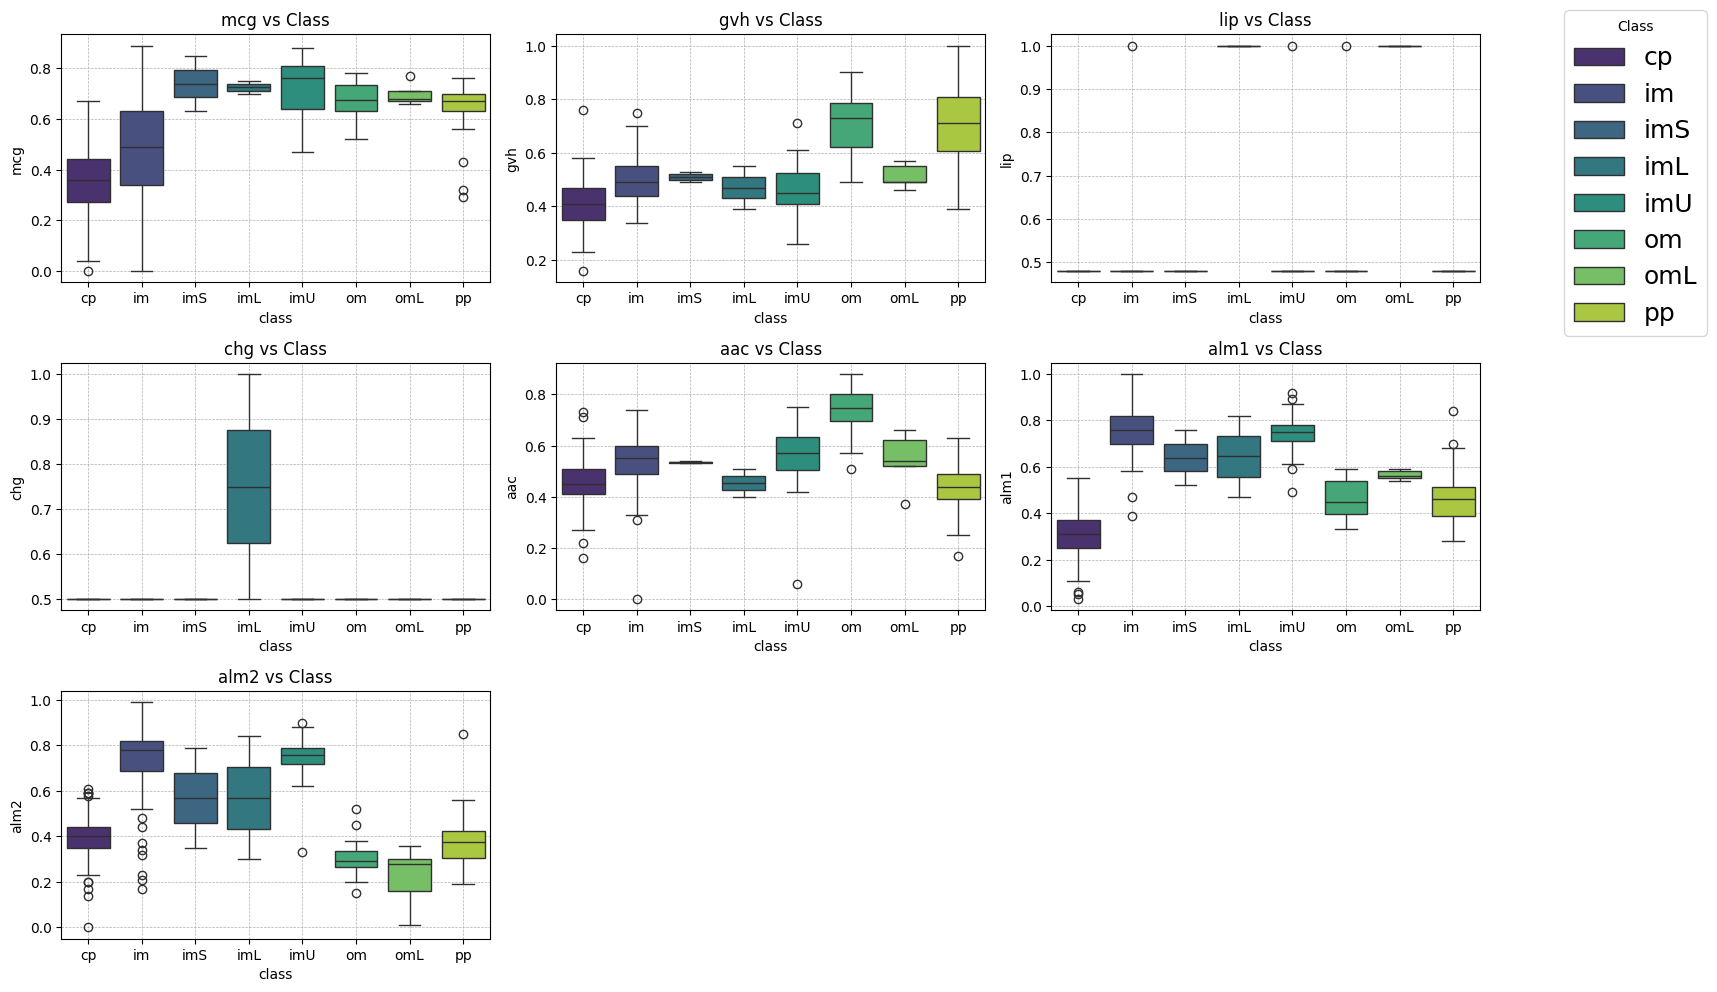

In [85]:
plt.figure(figsize=(15, 10))

labels = ['cp', 'im', 'imS', 'imL', 'imU', 'om', 'omL', 'pp']
colors = sns.color_palette('viridis', len(labels))

for i, col in enumerate(raw.select_dtypes(include='float64').columns):
    plt.subplot(3, 3, i+1)
    sns.boxplot(data=raw, x='class', y=col, palette='viridis')
    plt.title(f'{col} vs Class')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()

plt.figlegend(labels, loc='upper right', title='Class', bbox_to_anchor=(1.15, 1), fontsize=18)

plt.show()


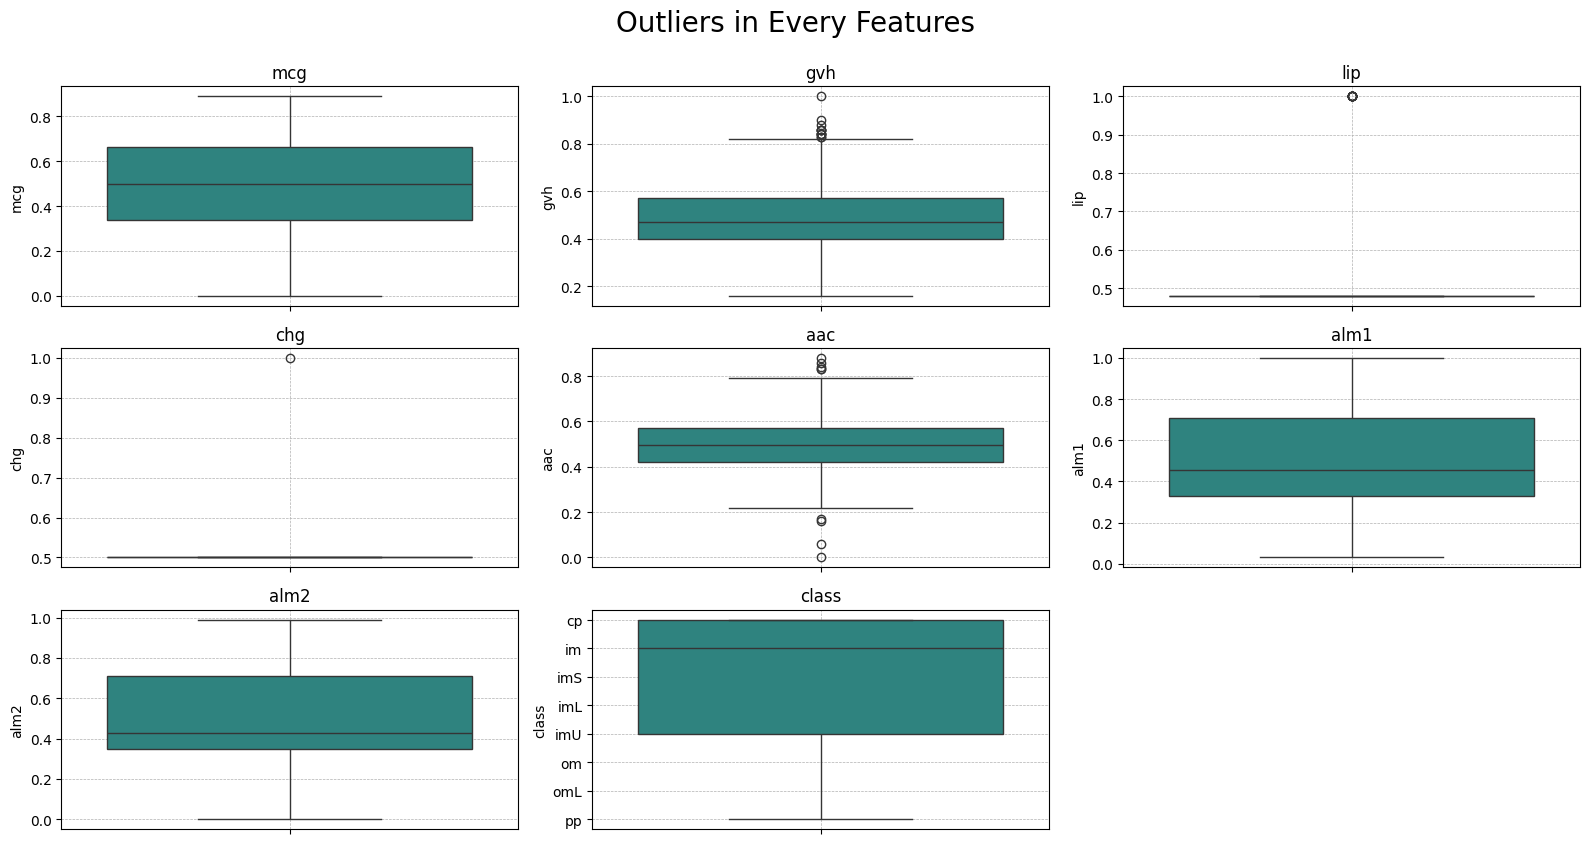

In [86]:
plt.figure(figsize=(16, 8))

for i, col in enumerate(raw.columns):
    plt.subplot(3, 3, i+1)
    sns.boxplot(data=raw, y=col, palette='viridis')
    plt.title(f'{col}')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()

plt.suptitle('Outliers in Every Features', fontsize=20, y=1.05)
plt.savefig('fig/outliers.png', dpi=300, bbox_inches='tight')
plt.show()

Based on the image above, there are quite lot for outliers to be removed in each classes by comparing with each feature.

## Code

### Data Fragmentation

It means that the `raw` dataframe will be fragmented to several different purposes of dataframes. Namely: `test_df` and `df`. The `test_df` will be used and applying the `StandardScaler()` function. While `df` will be the last resort of the dataframe and will be use as a comparison between *standardized* and vanilla dataset (*not standardized*).

In [87]:
df = raw.copy()
test_df = raw.copy()

assert df.shape == raw.shape and test_df.shape == raw.shape # checking if the dataframes are copied correctly
assert df.dtypes.all() == raw.dtypes.all() and test_df.dtypes.all() == raw.dtypes.all() # checking if the data types are copied correctly

### Outliers Removal

Outliers should be removed because they represent measurement errors, data entry or processing errors, or poor sampling.

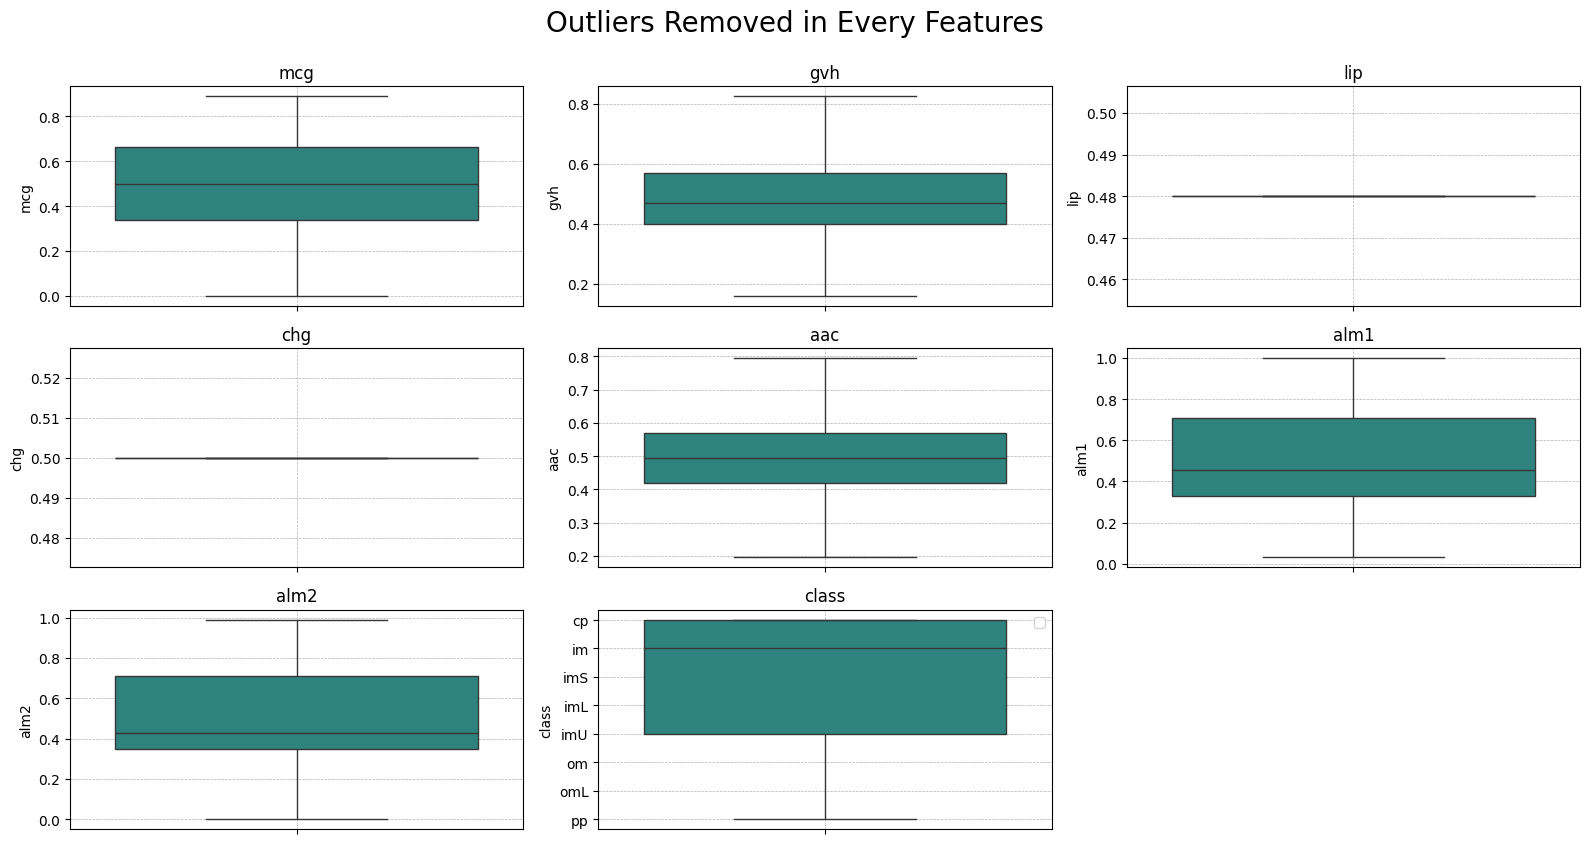

In [88]:
for col in df.columns[:-1]:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

plt.figure(figsize=(16, 8))

for i, col in enumerate(df.columns):
    plt.subplot(3, 3, i+1)
    sns.boxplot(data=df, y=col, palette='viridis')
    plt.title(f'{col}')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()

plt.legend()
plt.suptitle('Outliers Removed in Every Features', fontsize=20, y=1.05)
plt.savefig('fig/removed-outliers.png', dpi=300, bbox_inches='tight')
plt.show()

#### Before and After

<img src='fig/outliers.png'>
<img src='fig/removed-outliers.png'>

### Preprocessing Data

#### Standardizing Dataframe to `df_std`

In [89]:
std = StandardScaler()

df_std = pd.DataFrame(std.fit_transform(df.iloc[:, :-1]), columns=df.columns[:-1])
df_std

,mcg,gvh,lip,chg,aac,alm1,alm2
0,-0.051761,-1.447125,-1.110223e-16,0.0,0.512230,-1.207717,-0.716084
1,-2.212876,-0.683534,-1.110223e-16,0.0,0.340336,-0.697111,-0.285665
2,0.308424,-0.683534,-1.110223e-16,0.0,-0.089401,-0.604273,-0.190016
3,0.462790,-0.058777,-1.110223e-16,0.0,0.168441,-0.232923,-0.668259
4,-1.389594,-1.238872,-1.110223e-16,0.0,0.426283,-1.161299,-0.716084
...,...,...,...,...,...,...,...
331,1.234617,0.427144,-1.110223e-16,0.0,-0.261295,0.834709,-0.955205
332,1.080251,0.496561,-1.110223e-16,0.0,-0.175348,-0.697111,-0.859557
333,0.565700,0.704813,-1.110223e-16,0.0,-0.519137,-0.511436,-0.572611
334,0.462790,0.774231,-1.110223e-16,0.0,-0.691032,-0.372179,-0.620435


In [90]:
df_std = pd.concat([df_std, df['class']], axis=1)
df_std

,mcg,gvh,lip,chg,aac,alm1,alm2,class
0,-0.051761,-1.447125,-1.110223e-16,0.0,0.512230,-1.207717,-0.716084,cp
1,-2.212876,-0.683534,-1.110223e-16,0.0,0.340336,-0.697111,-0.285665,cp
2,0.308424,-0.683534,-1.110223e-16,0.0,-0.089401,-0.604273,-0.190016,cp
3,0.462790,-0.058777,-1.110223e-16,0.0,0.168441,-0.232923,-0.668259,cp
4,-1.389594,-1.238872,-1.110223e-16,0.0,0.426283,-1.161299,-0.716084,cp
...,...,...,...,...,...,...,...,...
331,1.234617,0.427144,-1.110223e-16,0.0,-0.261295,0.834709,-0.955205,pp
332,1.080251,0.496561,-1.110223e-16,0.0,-0.175348,-0.697111,-0.859557,pp
333,0.565700,0.704813,-1.110223e-16,0.0,-0.519137,-0.511436,-0.572611,pp
334,0.462790,0.774231,-1.110223e-16,0.0,-0.691032,-0.372179,-0.620435,pp


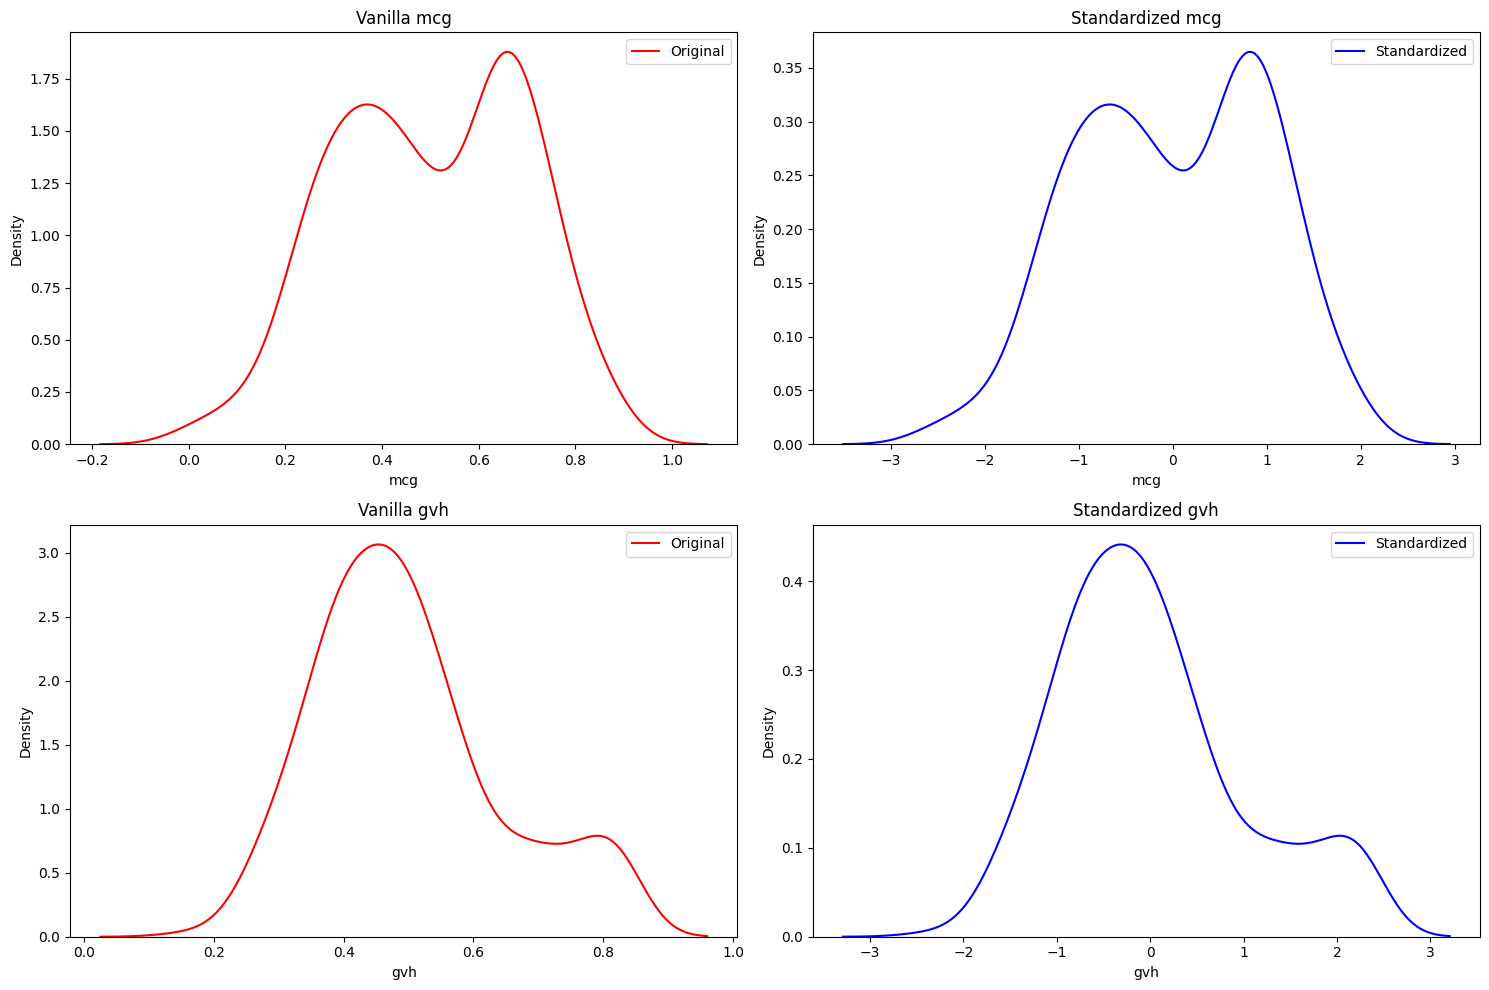

In [91]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))  # Increase height to better accommodate four subplots

sns.kdeplot(df['mcg'], ax=ax[0, 0], color='red', label='Original')
ax[0, 0].set_title('Vanilla mcg')
ax[0, 0].legend()

sns.kdeplot(df_std['mcg'], ax=ax[0, 1], color='blue', label='Standardized')
ax[0, 1].set_title('Standardized mcg')
ax[0, 1].legend()

sns.kdeplot(df['gvh'], ax=ax[1, 0], color='red', label='Original')
ax[1, 0].set_title('Vanilla gvh')
ax[1, 0].legend()

sns.kdeplot(df_std['gvh'], ax=ax[1, 1], color='blue', label='Standardized')
ax[1, 1].set_title('Standardized gvh')
ax[1, 1].legend()

plt.tight_layout()
plt.show()

The density plots indicate that standardization has appropriately rescaled the features while preserving their original distribution shapes, which is beneficial for the subsequent machine learning classification tasks.

## TPOT Usage

In this section, we will run the TPOT function to find the best machine learning algorithm. There will be several parts namely:

1. Label Encoding
   - In label encoding, we will convert all the current class target from a feature named `class`. Sice there are seven differents label, the label encoder will convert the label into a 1-7 scale.
2. Training
   - In training, this will involves several steps, namely tuning the hyperparameter (lots of testing), assess the time it took, and find the best machine learning algorithm through `TPOTClassifier` function.
3. Fitting
4. Validating
5. Score Report

In [108]:
label_encoder = LabelEncoder()
df_std['class'] = label_encoder.fit_transform(df_std['class'])

x = df_std.drop('class', axis=1)
y = df_std['class']

X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.75, test_size=0.25, random_state=42, shuffle=True)


In [93]:
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [109]:
model = TPOTClassifier(
    verbosity=3, 
    generations=100, 
    population_size=100, 
    random_state=42,
    cv=5,
    early_stop=10,
    n_jobs=-1, 
    periodic_checkpoint_folder='tpot_checkpoints'
)

time_start = time.time()

# Train the Classifier
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


32 operators have been imported by TPOT.
_pre_test decorator: _random_mutation_operator: num_test=0 Negative values in data passed to MultinomialNB (input X).
_pre_test decorator: _random_mutation_operator: num_test=0 Solver lbfgs supports only 'l2' or None penalties, got l1 penalty..
                                                                                
Generation 1 - Current Pareto front scores:
                                                                                
-1	0.8450980392156863	LinearSVC(input_matrix, LinearSVC__C=0.1, LinearSVC__dual=False, LinearSVC__loss=squared_hinge, LinearSVC__penalty=l2, LinearSVC__tol=0.0001)
                                                                                
-2	0.8492549019607842	GradientBoostingClassifier(RobustScaler(input_matrix), GradientBoostingClassifier__learning_rate=0.1, GradientBoostingClassifier__max_depth=7, GradientBoostingClassifier__max_features=0.8500000000000001, GradientBoostingClassifier__min_sampl

In [110]:
print(model.score(X_test, y_test))
print('\nTime used with num_cpu = 3:', time.time() - time_start)

print("Classification Report:")
print(classification_report(y_test, y_pred))

0.9047619047619048

Time used with num_cpu = 3: 2983.5501329898834
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95        40
           1       0.88      0.88      0.88        17
           3       0.00      0.00      0.00         1
           4       1.00      0.80      0.89         5
           5       1.00      1.00      1.00         6
           6       0.50      1.00      0.67         1
           7       0.85      0.79      0.81        14

    accuracy                           0.90        84
   macro avg       0.74      0.78      0.74        84
weighted avg       0.90      0.90      0.90        84



In [111]:
model2 = TPOTClassifier(
    verbosity=3, 
    generations=20, 
    population_size=20, 
    random_state=42,
    early_stop=10,
    n_jobs=-1, 
    periodic_checkpoint_folder='tpot_checkpoints_2'
)

time_start = time.time()

# Train the Classifier
model2.fit(X_train, y_train)

y_pred2 = model2.predict(X_test)


32 operators have been imported by TPOT.
_pre_test decorator: _random_mutation_operator: num_test=0 Solver lbfgs supports only 'l2' or None penalties, got l1 penalty..
_pre_test decorator: _random_mutation_operator: num_test=0 Solver lbfgs supports only 'l2' or None penalties, got l1 penalty..
                                                                             
Generation 1 - Current Pareto front scores:
                                                                             
-1	0.8450196078431371	GaussianNB(input_matrix)
                                                                             
Generation 2 - Current Pareto front scores:
                                                                             
-1	0.8491764705882353	ExtraTreesClassifier(input_matrix, ExtraTreesClassifier__bootstrap=True, ExtraTreesClassifier__criterion=entropy, ExtraTreesClassifier__max_features=0.05, ExtraTreesClassifier__min_samples_leaf=1, ExtraTreesClassifier__min_samples_split

In [112]:
print(model2.score(X_test, y_test))
print('\nTime used:', time.time() - time_start)

print("Classification Report:")
print(classification_report(y_test, y_pred2))

0.8928571428571429

Time used: 77.25637364387512
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        40
           1       0.79      0.88      0.83        17
           3       0.00      0.00      0.00         1
           4       1.00      0.60      0.75         5
           5       0.86      1.00      0.92         6
           6       0.00      0.00      0.00         1
           7       0.92      0.79      0.85        14

    accuracy                           0.89        84
   macro avg       0.64      0.61      0.62        84
weighted avg       0.88      0.89      0.88        84



In [113]:
model3 = TPOTClassifier(
    verbosity=3, 
    generations=50, 
    population_size=50, 
    random_state=42,
    early_stop=10,
    n_jobs=-1, 
    periodic_checkpoint_folder='tpot_checkpoints_3'
)

time_start = time.time()

# Train the Classifier
model3.fit(X_train, y_train)

y_pred3 = model3.predict(X_test)


32 operators have been imported by TPOT.
_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False.
_pre_test decorator: _random_mutation_operator: num_test=0 Solver lbfgs supports only 'l2' or None penalties, got l1 penalty..
_pre_test decorator: _random_mutation_operator: num_test=0 Negative values in data passed to MultinomialNB (input X).
_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False.
_pre_test decorator: _random_mutation_operator: num_test=0 Solver lbfgs supports only 'l2' or None penalties, got l1 penalty..
                                                                              
Generation 1 - Current Pareto front scores:
                               

In [114]:
print(model2.score(X_test, y_test))
print('\nTime used:', time.time() - time_start)

print("Classification Report:")
print(classification_report(y_test, y_pred3))

0.8928571428571429

Time used: 139.14797449111938
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        40
           1       0.83      0.88      0.86        17
           3       0.00      0.00      0.00         1
           4       1.00      0.60      0.75         5
           5       0.86      1.00      0.92         6
           6       0.00      0.00      0.00         1
           7       0.92      0.86      0.89        14

    accuracy                           0.90        84
   macro avg       0.65      0.62      0.63        84
weighted avg       0.89      0.90      0.89        84



### Vanilla Dataframe (Not Standardized)

In [115]:
label_encoder = LabelEncoder()
df['class'] = label_encoder.fit_transform(df['class'])

x = df.drop('class', axis=1)
y = df['class']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(x, y, train_size=0.75, test_size=0.25, random_state=42, shuffle=True)


In [116]:
model4 = TPOTClassifier(
    verbosity=3, 
    generations=20, 
    population_size=20, 
    random_state=42,
    early_stop=10,
    n_jobs=-1, 
    periodic_checkpoint_folder='tpot_checkpoints'
)

time_start = time.time()

# Train the Classifier
model4.fit(X_train_2, y_train_2)

y_pred4 = model4.predict(X_test_2)


32 operators have been imported by TPOT.
_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False.
                                                                             
Generation 1 - Current Pareto front scores:
                                                                             
-1	0.8450196078431371	GaussianNB(input_matrix)
_pre_test decorator: _random_mutation_operator: num_test=0 Solver lbfgs supports only dual=False, got dual=True.
                                                                             
Generation 2 - Current Pareto front scores:
                                                                             
-1	0.8450196078431371	GaussianNB(input_matrix)
                                                                             
Generation 3 - Current Pareto front scores:
                      

In [117]:
print(model4.score(X_test_2, y_test_2))

print("Classification Report:")
print(classification_report(y_test_2, y_pred4))

0.9047619047619048
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        40
           1       0.83      0.88      0.86        17
           3       0.00      0.00      0.00         1
           4       1.00      0.80      0.89         5
           5       0.86      1.00      0.92         6
           6       0.00      0.00      0.00         1
           7       0.92      0.79      0.85        14

    accuracy                           0.90        84
   macro avg       0.65      0.64      0.64        84
weighted avg       0.89      0.90      0.89        84



In [118]:
model5 = TPOTClassifier(
    verbosity=3, 
    generations=50, 
    population_size=50, 
    random_state=42,
    early_stop=10,
    n_jobs=-1, 
    periodic_checkpoint_folder='tpot_checkpoints'
)

# Train the Classifier
model5.fit(X_train_2, y_train_2)

y_pred5 = model5.predict(X_test_2)


32 operators have been imported by TPOT.
_pre_test decorator: _random_mutation_operator: num_test=0 Solver lbfgs supports only dual=False, got dual=True.
_pre_test decorator: _random_mutation_operator: num_test=1 Solver lbfgs supports only 'l2' or None penalties, got l1 penalty..
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
                                                                              
Generation 1 - Current Pareto front scores:
                                                                               
-1	0.8450196078431371	GaussianNB(input_matrix)
                                                                               
-2	0.852862745098039	LogisticRegression(RBFSampler(input_matrix, RBFSampler__gamma=0.8500000000000001), LogisticRegression__C=25.0, LogisticRegression__dual=False, LogisticRegression__penalty=l2)
_pre_test decorator: _random_mutation_operator: num_test=0

In [119]:
print(model5.score(X_test_2, y_test_2))

print("Classification Report:")
print(classification_report(y_test_2, y_pred5))

0.9166666666666666
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        40
           1       0.83      0.88      0.86        17
           3       0.00      0.00      0.00         1
           4       1.00      0.80      0.89         5
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         1
           7       0.92      0.79      0.85        14

    accuracy                           0.92        84
   macro avg       0.81      0.78      0.79        84
weighted avg       0.91      0.92      0.91        84



In [120]:
model.export('tpot_pipeline.py')

Based on the several test and test case, the best results generated by Vanilla dataset with removed outliers as it can seen in the last test that achieves 0.92 in F1-score and using LogisticRegression() model.